In [13]:
import scipy.io as sio

# Load the .mat file
file_path = '/content/umist_cropped.mat'
data = sio.loadmat(file_path)

# Display the keys to understand the structure of the dataset
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'facedat', 'dirnames'])

In [14]:
# Check the structure and size of 'facedat'
facedat = data['facedat']
facedat_shape = facedat.shape

# Check the contents of 'dirnames'
dirnames = data['dirnames']
dirnames_contents = dirnames

facedat_shape, dirnames_contents


((1, 20),
 array([[array(['1a'], dtype='<U2'), array(['1b'], dtype='<U2'),
         array(['1c'], dtype='<U2'), array(['1d'], dtype='<U2'),
         array(['1e'], dtype='<U2'), array(['1f'], dtype='<U2'),
         array(['1g'], dtype='<U2'), array(['1h'], dtype='<U2'),
         array(['1i'], dtype='<U2'), array(['1j'], dtype='<U2'),
         array(['1k'], dtype='<U2'), array(['1l'], dtype='<U2'),
         array(['1m'], dtype='<U2'), array(['1n'], dtype='<U2'),
         array(['1o'], dtype='<U2'), array(['1p'], dtype='<U2'),
         array(['1q'], dtype='<U2'), array(['1r'], dtype='<U2'),
         array(['1s'], dtype='<U2'), array(['1t'], dtype='<U2')]],
       dtype=object))

In [15]:
# Extract and inspect the first element of 'facedat' to understand its structure
first_face_data = facedat[0, 0]

# Check the type and shape of the first face data instance
type(first_face_data), first_face_data.shape if hasattr(first_face_data, 'shape') else 'No shape attribute'


(numpy.ndarray, (112, 92, 38))

In [16]:
# Verify the structure and consistency across all entries in 'facedat'
all_shapes = [facedat[0, i].shape for i in range(facedat.shape[1])]

# Check if all shapes are consistent
consistent_shapes = all(shape == all_shapes[0] for shape in all_shapes)

all_shapes, consistent_shapes


([(112, 92, 38),
  (112, 92, 35),
  (112, 92, 26),
  (112, 92, 24),
  (112, 92, 26),
  (112, 92, 23),
  (112, 92, 19),
  (112, 92, 22),
  (112, 92, 20),
  (112, 92, 32),
  (112, 92, 34),
  (112, 92, 34),
  (112, 92, 26),
  (112, 92, 30),
  (112, 92, 19),
  (112, 92, 26),
  (112, 92, 26),
  (112, 92, 33),
  (112, 92, 48),
  (112, 92, 34)],
 False)

In [17]:
# Verify the structure and consistency across all entries in 'facedat'
all_shapes = [facedat[0, i].shape for i in range(facedat.shape[1])]

# Check if all shapes are consistent
consistent_shapes = all(shape == all_shapes[0] for shape in all_shapes)

all_shapes, consistent_shapes


([(112, 92, 38),
  (112, 92, 35),
  (112, 92, 26),
  (112, 92, 24),
  (112, 92, 26),
  (112, 92, 23),
  (112, 92, 19),
  (112, 92, 22),
  (112, 92, 20),
  (112, 92, 32),
  (112, 92, 34),
  (112, 92, 34),
  (112, 92, 26),
  (112, 92, 30),
  (112, 92, 19),
  (112, 92, 26),
  (112, 92, 26),
  (112, 92, 33),
  (112, 92, 48),
  (112, 92, 34)],
 False)

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

# Normalize pixel values to range [0, 1]
normalized_faces = [facedat[0, i] / 255.0 for i in range(facedat.shape[1])]

# Perform stratified split for training, validation, and test sets
train_data, val_test_data = [], []
val_data, test_data = [], []

# Split for each individual's images
for images in normalized_faces:
    n_images = images.shape[-1]
    indices = np.arange(n_images)

    # Split into training (70%) and remaining (30%)
    train_idx, val_test_idx = train_test_split(indices, test_size=0.3, random_state=42)
    train_data.append(images[..., train_idx])
    val_test_data.append(images[..., val_test_idx])

    # Split remaining into validation (50%) and test (50%)
    val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)
    val_data.append(images[..., val_idx])
    test_data.append(images[..., test_idx])

# Combine all data sets into arrays
train_data = np.concatenate(train_data, axis=-1)
val_data = np.concatenate(val_data, axis=-1)
test_data = np.concatenate(test_data, axis=-1)

train_data.shape, val_data.shape, test_data.shape


((112, 92, 395), (112, 92, 86), (112, 92, 94))

In [19]:
from sklearn.decomposition import PCA

# Flatten images for PCA
train_flat = train_data.reshape(-1, train_data.shape[-1]).T  # (num_images, pixels)
val_flat = val_data.reshape(-1, val_data.shape[-1]).T
test_flat = test_data.reshape(-1, test_data.shape[-1]).T

# Apply PCA to reduce dimensionality, preserving 95% variance
pca = PCA(0.95, random_state=42)
train_pca = pca.fit_transform(train_flat)
val_pca = pca.transform(val_flat)
test_pca = pca.transform(test_flat)

# Check the reduced dimensionality
train_pca.shape, val_pca.shape, test_pca.shape, pca.n_components_


((395, 94), (86, 94), (94, 94), 94)

In [20]:
from sklearn.cluster import KMeans

# Number of clusters (assume one cluster per individual)
n_clusters = len(normalized_faces)

# Apply K-Means clustering on training data
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(train_pca)

# Analyze cluster assignments
unique_clusters, cluster_counts = np.unique(kmeans_labels, return_counts=True)

unique_clusters, cluster_counts


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 array([12, 35, 31, 38, 23, 32,  7,  7, 17, 16, 26, 40, 10, 11, 14, 13, 19,
        12, 17, 15]))

In [ ]:
# Analyze the unique labels in training and validation sets
train_labels = kmeans_labels  # Using K-Means as labels for now
val_labels = np.zeros(val_pca.shape[0])  # Placeholder, will need adjustment

# Check consistency across labels in training
unique_train_labels = np.unique(train_labels)

unique_train_labels, len(unique_train_labels)  # Number of unique clusters (should be 20)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 20)

In [23]:
# Assign cluster-based labels to validation data using the trained K-Means model
val_labels_corrected = kmeans.predict(val_pca)

# Check the distribution of labels in the validation set
unique_val_labels, val_label_counts = np.unique(val_labels_corrected, return_counts=True)

unique_val_labels, val_label_counts  # Distribution of labels in the validation set


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 array([ 3,  7,  7,  9,  4,  5,  2,  1,  2,  6,  5, 10,  1,  2,  3,  3,  5,
         3,  6,  2]))

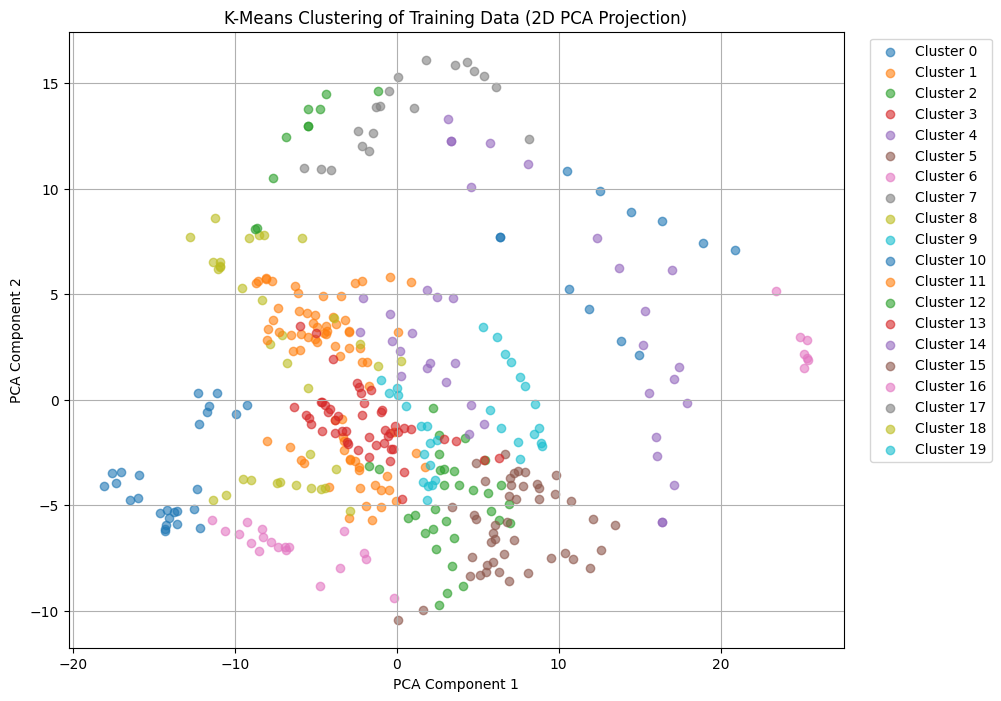

In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce PCA-transformed data to 2D for visualization
pca_2d = PCA(n_components=2, random_state=42)
train_2d = pca_2d.fit_transform(train_pca)

# Plot the clusters in 2D space
plt.figure(figsize=(10, 8))
for cluster in np.unique(kmeans_labels):
    cluster_points = train_2d[kmeans_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-Means Clustering of Training Data (2D PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid()
plt.show()


In [25]:
import tensorflow as tf

In [26]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the neural network architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(train_pca.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(n_clusters, activation='softmax')  # Output layer for 20 classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │          12,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,716 (84.83 KB)

 Trainable params: 21,716 (84.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0886 - loss: 3.5676 - val_accuracy: 0.4302 - val_loss: 2.2343
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3099 - loss: 2.3697 - val_accuracy: 0.7791 - val_loss: 1.5879
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5048 - loss: 1.7723 - val_accuracy: 0.8605 - val_loss: 1.0670
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6670 - loss: 1.2511 - val_accuracy: 0.8953 - val_loss: 0.7024
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7633 - loss: 0.8563 - val_accuracy: 0.9070 - val_loss: 0.4775
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8262 - loss: 0.6521 - val_accuracy: 0.9302 - val_loss: 0.3442
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8463 - loss: 0.5317 - val_accuracy: 0.9535 - val_loss: 0.2668
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8389 - loss: 0.5399 - val_accuracy: 0.9186 - val_loss:

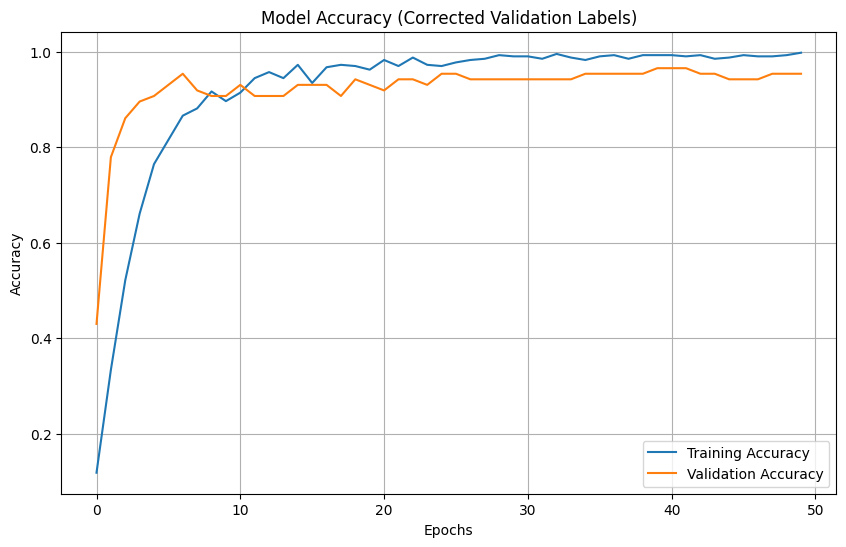

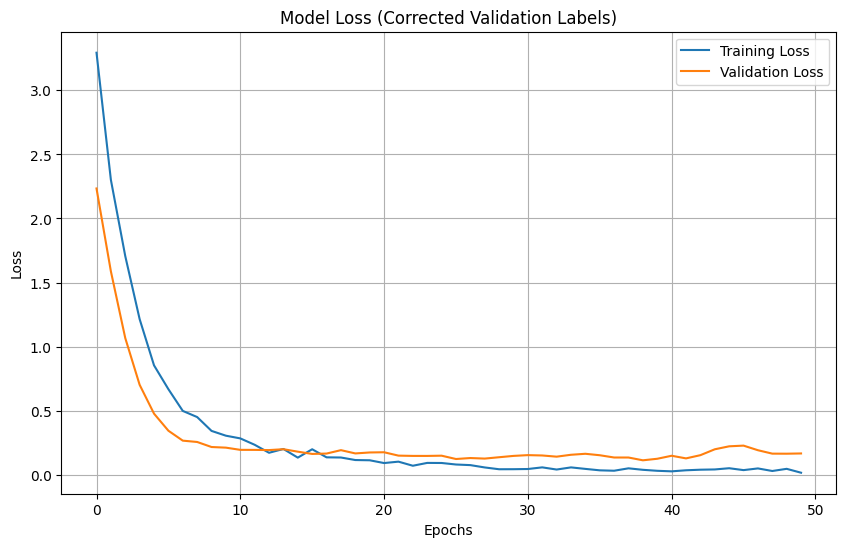

In [27]:
history_corrected = model.fit(
    train_pca,
    train_labels,  # Correct training labels (from K-Means clustering)
    validation_data=(val_pca, val_labels_corrected),  # Corrected validation labels
    epochs=50,
    batch_size=16,
    verbose=1
)

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history_corrected.history['accuracy'], label='Training Accuracy')
plt.plot(history_corrected.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Corrected Validation Labels)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_corrected.history['loss'], label='Training Loss')
plt.plot(history_corrected.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Corrected Validation Labels)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [28]:
# Predict and evaluate on the test set
test_labels_corrected = kmeans.predict(test_pca)  # Correct test labels
test_loss, test_accuracy = model.evaluate(test_pca, test_labels_corrected, verbose=1)

print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9198 - loss: 0.2920 
Test Accuracy: 0.93, Test Loss: 0.26


In [30]:
model.save("my_model.keras")


In [31]:
from tensorflow.keras.models import load_model
model = load_model("/content/my_model.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [32]:
# Predict labels for the test set
test_predictions = model.predict(test_pca)
predicted_labels = np.argmax(test_predictions, axis=1)  # Get the class with the highest probability

# Compare predicted labels with true labels
comparison = list(zip(predicted_labels, test_labels_corrected))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [33]:
# Display predicted and true labels for the first 10 test samples
for i, (predicted, true) in enumerate(comparison[:10]):
    print(f"Sample {i+1}: Predicted = {predicted}, True = {true}")


Sample 1: Predicted = 0, True = 0
Sample 2: Predicted = 17, True = 17
Sample 3: Predicted = 6, True = 6
Sample 4: Predicted = 0, True = 6
Sample 5: Predicted = 6, True = 6
Sample 6: Predicted = 17, True = 17
Sample 7: Predicted = 0, True = 0
Sample 8: Predicted = 12, True = 12
Sample 9: Predicted = 0, True = 0
Sample 10: Predicted = 12, True = 4


In [34]:
test_loss, test_accuracy = model.evaluate(test_pca, test_labels_corrected, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9198 - loss: 0.2920  
Test Accuracy: 0.93, Test Loss: 0.26
